In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv


# Data Importation

In [2]:
dftrain = pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv")
dfval = pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv")
dfsample = pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv")

# Importing Required Libraries and Frameworks

In [3]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Importing machine learning modules
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Importing text processing and feature selection modules
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2

# Importing evaluation metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc, roc_auc_score

# Transforming 'CreationTimestamp' Column

In [4]:
d = dftrain["CreationTimestamp"]
dft = pd.DataFrame(d)

# Function to convert Unix timestamp to hour of the day and day of the week
def convert_timestamp(timestamp):
    dt_object = dt.datetime.fromtimestamp(timestamp)
    hour_of_day = dt_object.hour
    day_of_week = dt_object.weekday()
    return hour_of_day, day_of_week

dft[['HourOfDay', 'DayOfWeek']] = dft['CreationTimestamp'].apply(lambda x: pd.Series(convert_timestamp(x)))


dftrain['HourOfDay'] = dft[['HourOfDay']]
dftrain['DayOfWeek'] = dft[['DayOfWeek']]
dftrain['DayOfWeek'].value_counts()

DayOfWeek
3    12667
2      446
0      140
1      111
4       97
5       94
6       81
Name: count, dtype: int64

# Exploratory Data Analysis (EDA) and Data Cleaning

In [5]:
dftrain.head()

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review,HourOfDay,DayOfWeek
0,70,71,12259,Banana Bars with Cream Cheese Frosting,sp_aUSaElGf_12259_c_149978,u_1oKVaBmiEKwAFyiHrDLoWpbel0J,misscoffeepot,20,1622717078,0,0,0,5,100,great recipe! I have made them just as written...,10,3
1,72,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_310332,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,MichelleMalone,1,1622717852,0,0,1,5,100,This is an easy and quick recipe that is great...,10,3
2,458,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_206522,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,jeannem32,1,1622717357,0,0,0,3,100,I think I was looking for something extra spec...,10,3
3,7,50,100276,Grilled Huli Huli Chicken,sp_aUSaElGf_100276_c_434088,u_1oKZCQcKQZdQhDVBS7oISc216VA,ds422,1,1622648899,0,0,0,5,100,This is our favorite grilled chicken recipe. ...,15,2
4,60,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_387011,u_1oKd4sudZQPgu6YALiC7bW7mKMs,SusanHoward,1,1622718260,0,0,0,4,100,Great basic recipe. I added 2 teaspoons Tuscan...,11,3


In [6]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13636 non-null  int64 
 1   RecipeNumber       13636 non-null  int64 
 2   RecipeCode         13636 non-null  int64 
 3   RecipeName         13636 non-null  object
 4   CommentID          13636 non-null  object
 5   UserID             13636 non-null  object
 6   UserName           13636 non-null  object
 7   UserReputation     13636 non-null  int64 
 8   CreationTimestamp  13636 non-null  int64 
 9   ReplyCount         13636 non-null  int64 
 10  ThumbsUpCount      13636 non-null  int64 
 11  ThumbsDownCount    13636 non-null  int64 
 12  Rating             13636 non-null  int64 
 13  BestScore          13636 non-null  int64 
 14  Recipe_Review      13634 non-null  object
 15  HourOfDay          13636 non-null  int64 
 16  DayOfWeek          13636 non-null  int64

In [7]:
dftrain.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,13636.0,1.210853e+02,1.169956e+02,0.000000e+00,4.500000e+01,9.100000e+01,1.480000e+02,7.240000e+02
RecipeNumber,13636.0,3.862438e+01,2.967235e+01,1.000000e+00,1.200000e+01,3.300000e+01,6.300000e+01,1.000000e+02
RecipeCode,13636.0,2.178599e+04,2.388319e+04,3.860000e+02,6.504000e+03,1.460000e+04,3.312100e+04,1.917750e+05
UserReputation,13636.0,2.160311e+00,1.008642e+01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.100000e+02
CreationTimestamp,13636.0,1.623713e+09,5.444020e+06,1.613035e+09,1.622717e+09,1.622718e+09,1.622718e+09,1.665756e+09
ReplyCount,13636.0,1.452039e-02,1.373234e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
ThumbsUpCount,13636.0,1.098269e+00,4.166487e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.000000e+01
ThumbsDownCount,13636.0,5.437078e-01,3.265660e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.260000e+02
Rating,13636.0,4.288721e+00,1.544839e+00,0.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
BestScore,13636.0,1.531279e+02,1.409869e+02,0.000000e+00,1.000000e+02,1.000000e+02,1.000000e+02,9.460000e+02


In [8]:
dftrain.isna().sum()

ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
Rating               0
BestScore            0
Recipe_Review        2
HourOfDay            0
DayOfWeek            0
dtype: int64

In [9]:
print(dftrain.shape)
dftrain_1 = dftrain.dropna()
print(dftrain_1.shape)

(13636, 17)
(13634, 17)


<Axes: >

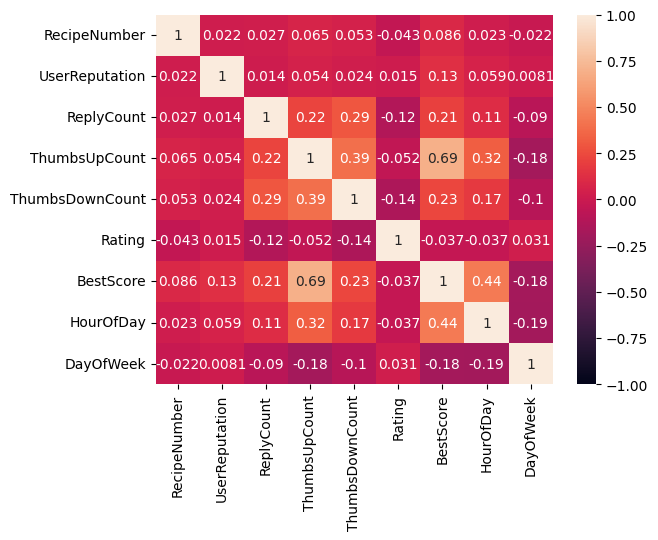

In [10]:
excluded_columns = ["ID","RecipeCode","RecipeName","CommentID","UserID","UserName","Recipe_Review","CreationTimestamp"]

correlation = dftrain_1.drop(excluded_columns,axis=1)
sns.heatmap(correlation.corr(), vmin=-1, vmax=1, annot=True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

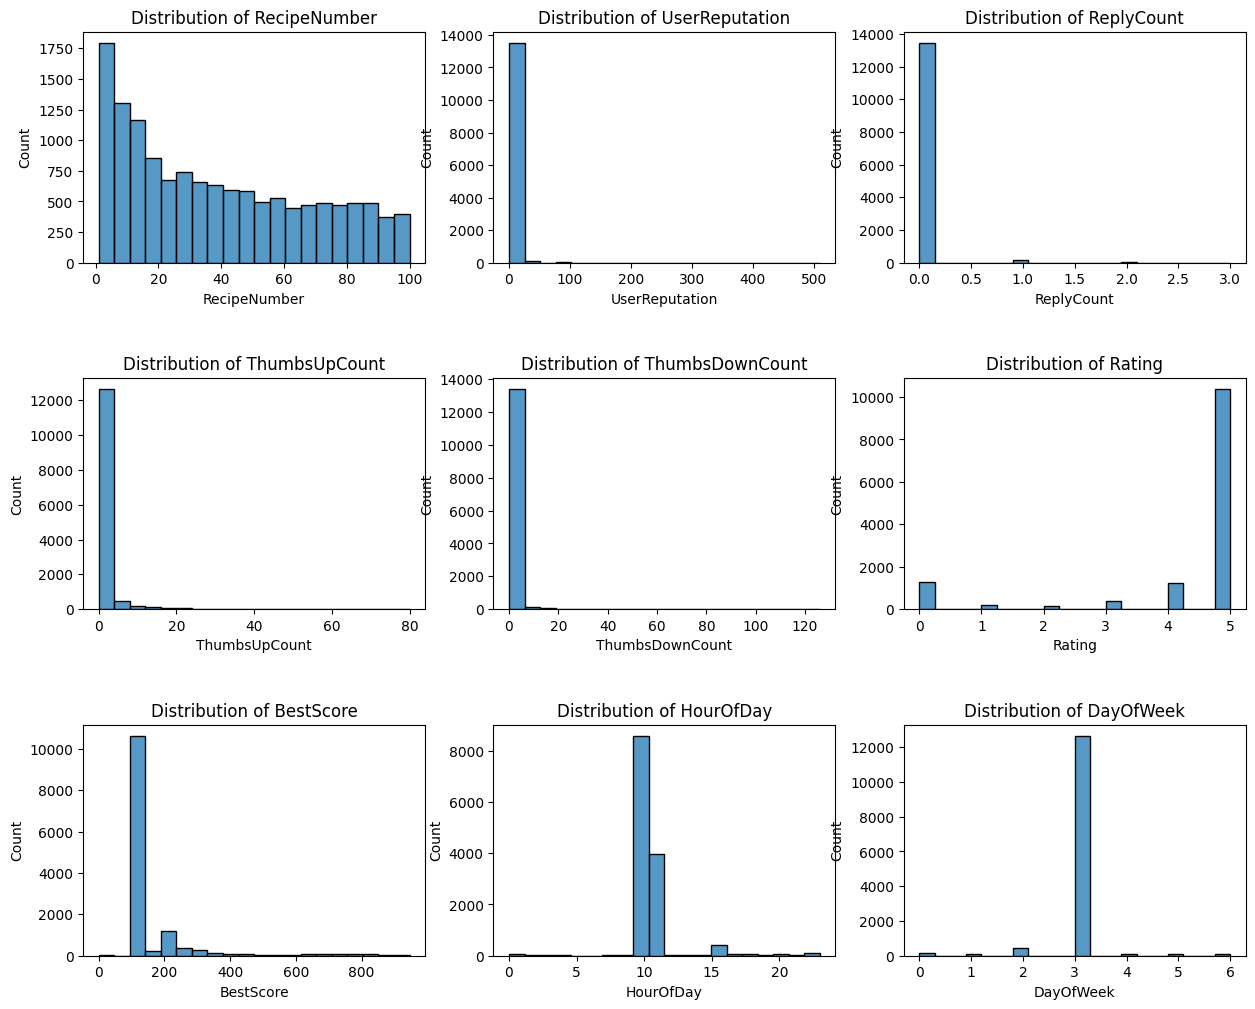

In [11]:
# Setting up the figure and axes
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
fig.subplots_adjust(hspace=0.5)  

columns = dftrain_1.drop(excluded_columns,axis=1)

for i, column in enumerate(columns):
    row = i // 3
    col = i % 3
    sns.histplot(dftrain_1[column], bins=20, kde=False, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {column}')

plt.show()

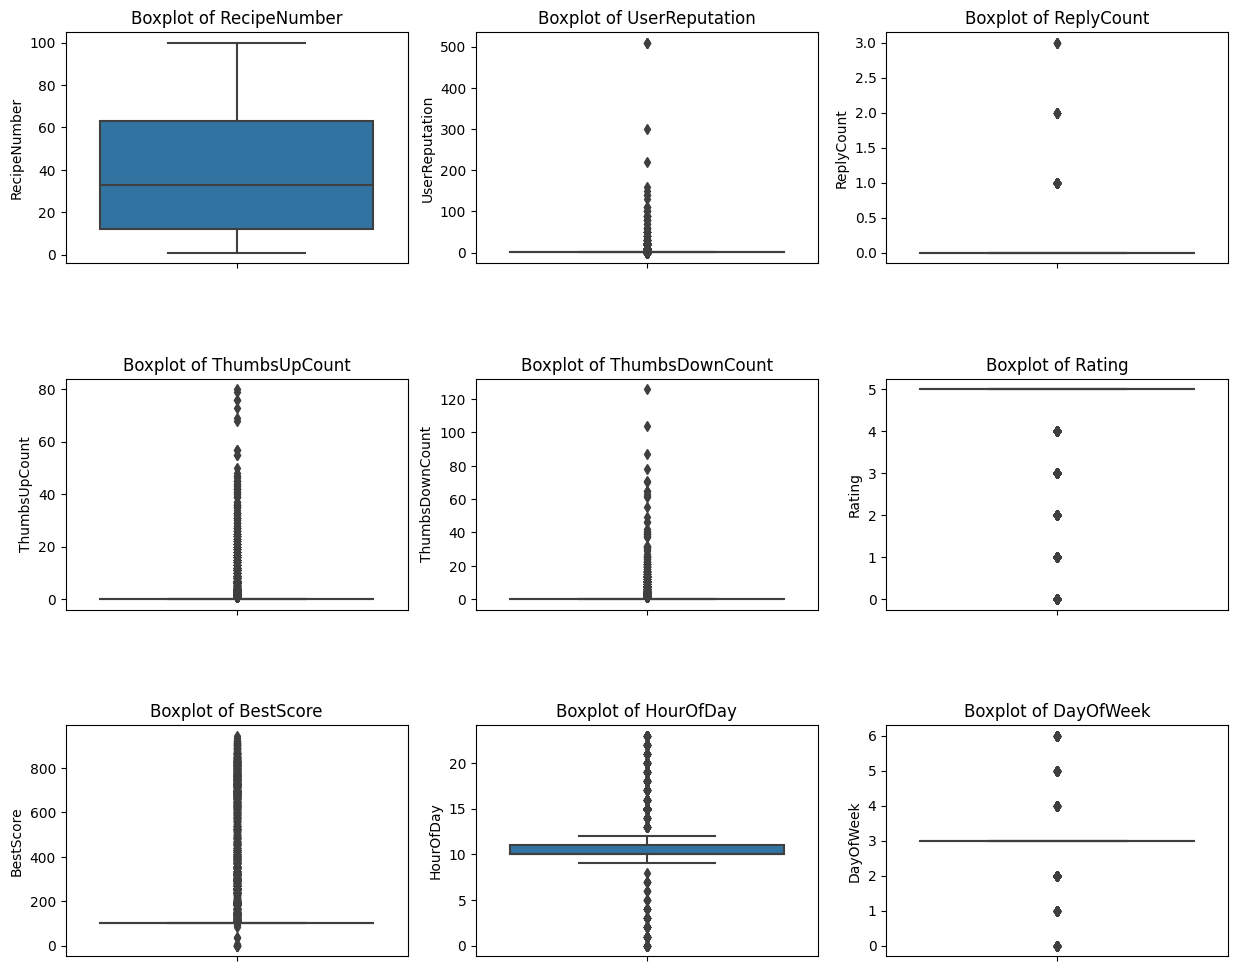

In [12]:
# Setting up the figure and axes
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
fig.subplots_adjust(hspace=0.5)  

columns = dftrain_1.drop(excluded_columns, axis=1)

for i, column in enumerate(columns):
    row = i // 3
    col = i % 3
    sns.boxplot(y=dftrain_1[column], ax=axes[row, col])
    axes[row, col].set_title(f'Boxplot of {column}')

plt.show()

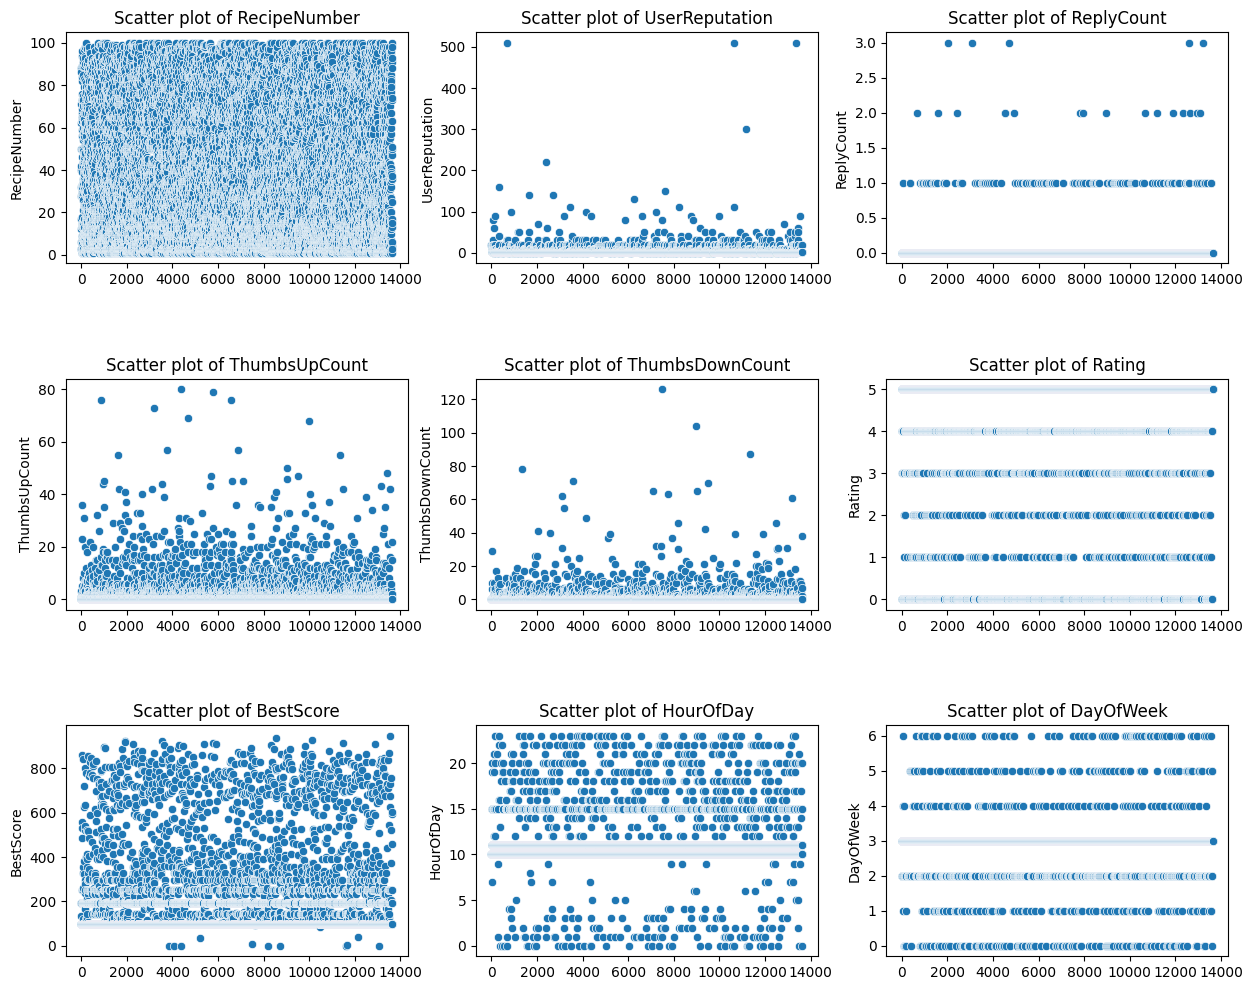

In [13]:
# Setting up the figure and axes
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
fig.subplots_adjust(hspace=0.5)  

columns = dftrain_1.drop(excluded_columns, axis=1)

for i, column in enumerate(columns):
    row = i // 3
    col = i % 3
    sns.scatterplot(x=dftrain_1.index, y=dftrain_1[column], ax=axes[row, col])
    axes[row, col].set_title(f'Scatter plot of {column}')

plt.show()

In [14]:
ytrain_counts = dftrain_1['Rating'].value_counts()
ytrain_counts

Rating
5    10369
0     1272
4     1241
3      368
1      210
2      174
Name: count, dtype: int64

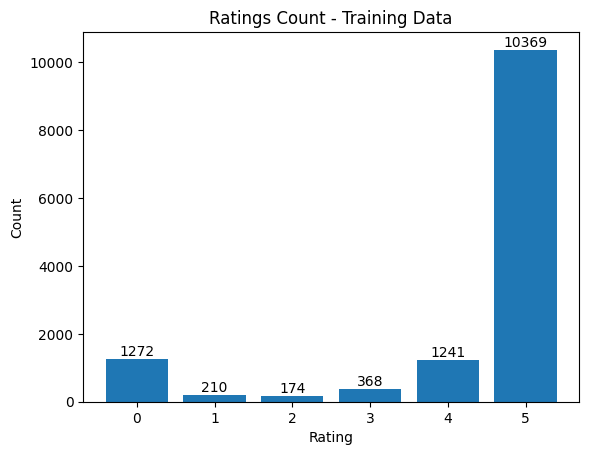

In [32]:
fig,ax = plt.subplots()
ax.bar(
    list(dftrain_1['Rating'].unique()),
    [ytrain_counts.loc[i] for i in list(dftrain_1['Rating'].unique())]
)

# Showing value labels
ax.bar_label(ax.containers[0], label_type='edge')

ax.set_title("Ratings Count - Training Data")
ax.set_xlabel("Rating")
ax.set_ylabel("Count")

plt.show()

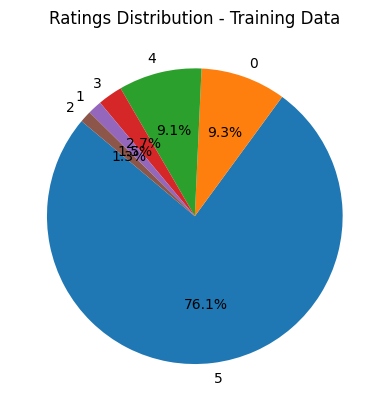

In [33]:
fig, ax = plt.subplots()

ratings_counts = dftrain_1['Rating'].value_counts()

ax.pie(ratings_counts, labels=ratings_counts.index, autopct='%1.1f%%', startangle=140)
ax.set_title("Ratings Distribution - Training Data")

plt.show()

## Choice of Features

Given the negligible correlation between negative features and the label vector, the decision was made to utilize the 'Recipe_Review' text column for model training. Despite attempts to incorporate numeric features in baseline models, no combination yielded satisfactory accuracy. This indicates that the numeric features alone did not provide sufficient predictive power.

Conversely, employing the 'Recipe_Review' text column, transformed using TFIDF vectorizer, consistently achieved the desired accuracy. Integrating numeric columns alongside 'Recipe_Review' led to overfitting during training and failed to reach the stipulated accuracy threshold during testing.Consequently, these columns were omitted as they only served to diminish overall model accuracy. 




# Train Test Split

In [15]:
xtrain,xtest,ytrain,ytest = train_test_split(dftrain_1['Recipe_Review'], dftrain_1['Rating'], test_size=0.2, shuffle=True, stratify=dftrain_1['Rating'],
                                              random_state=55)
xtrain.shape,ytrain.shape, xtest.shape,ytest.shape

((10907,), (10907,), (2727,), (2727,))

# Logistic Regression

In [16]:
# Defining the parameters grid
#param_grid = {
#    'Logistic__penalty': ['l1', 'l2'],
#    'Logistic__C':  [0.1, 1, 10],
#    'Logistic__solver': ['saga'],
#    'Logistic__max_iter':[500,800,1000],
#    "tfidf_vectorizer__ngram_range":[(1,2),(2,2)],
#    "tfidf_vectorizer__max_df":[0.1,0.2,0.3],
#    "tfidf_vectorizer__sublinear_tf":[True,False]
#}

# Creating a pipeline with TfidfVectorizer and LogisticRegression
#pipe = Pipeline([('tfidf_vectorizer',TfidfVectorizer()),('Logistic',LogisticRegression())])


#grid_search = GridSearchCV(estimator=pipe,
#                           param_grid=param_grid,
#                           cv=5,
#                           scoring='accuracy',
#                           verbose=1,
#                           n_jobs=-1)


#grid_search.fit(xtrain, ytrain)
#print("Best Parameters:", grid_search.best_params_)

# Getting the best model
#best_model = grid_search.best_estimator_

# Evaluating the best model on the test set
#test_accuracy = best_model.score(xtest, ytest)
#print("Test Accuracy:", test_accuracy)

## Best Parameters: LogisticRegression

Post fitting 5 folds for each of 216 candidates, totalling 1080 fits, the best parameters have been mentioned below -  

Best Parameters: {'Logistic__C': 10, 'Logistic__max_iter': 500, 'Logistic__penalty': 'l2', 'Logistic__solver': 'saga', 'tfidf_vectorizer__max_df': 0.3, 'tfidf_vectorizer__ngram_range': (1, 2), 'tfidf_vectorizer__sublinear_tf': True}


Test Accuracy: 0.7873120645397873

In [17]:
#Logistic Regression on Best Parameters

# Creating a pipeline with TfidfVectorizer and LogisticRegression
pipe_logistic = Pipeline([('tfidf_vectorizer',TfidfVectorizer(ngram_range=(1, 2),max_df=0.3, sublinear_tf=True)),
                 ('Logistic',LogisticRegression(max_iter=500, C=10,penalty='l2',solver='saga',random_state=55))])


pipe_logistic.fit(xtrain, ytrain)

# Evaluating the model on the test set
test_accuracy = pipe_logistic.score(xtest, ytest)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.7873120645397873


In [18]:
# Predicting labels for the test set
y_pred = pipe_logistic.predict(xtest)

# Generating confusion matrix
conf_matrix_logistic = confusion_matrix(ytest, y_pred)

print("Confusion Matrix:")
print(conf_matrix_logistic)

Confusion Matrix:
[[  51    2    0    1    6  194]
 [   9    9    2    0    2   20]
 [   2    0    1    5    8   19]
 [   2    0    3    8   12   49]
 [   7    0    0    4   39  198]
 [  16    0    0    0   19 2039]]


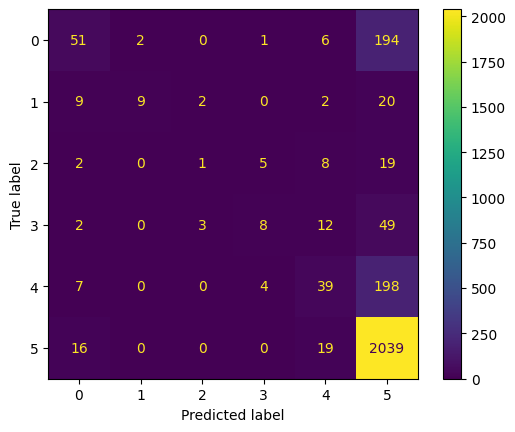

In [19]:
ConfusionMatrixDisplay(conf_matrix_logistic).plot()

In [20]:
# Predicting labels for the test set
y_pred = pipe_logistic.predict(xtest)

# Generating classification report
classification_report_logistic = classification_report(ytest, y_pred)

# Printing the report
print("Classification Report:")
print(classification_report_logistic)

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.20      0.30       254
           1       0.82      0.21      0.34        42
           2       0.17      0.03      0.05        35
           3       0.44      0.11      0.17        74
           4       0.45      0.16      0.23       248
           5       0.81      0.98      0.89      2074

    accuracy                           0.79      2727
   macro avg       0.55      0.28      0.33      2727
weighted avg       0.74      0.79      0.73      2727



# ROC

In [21]:
#Binarizing the target variable for multi-class classification
y_val_bin = label_binarize(ytest, classes=[0, 1, 2, 3, 4, 5])

# Getting predicted probabilities for each class
y_val_scores = pipe_logistic.predict_proba(xtest)

#Computing ROC curve and ROC area for each class
L = dict()
M = dict()
roc_auc = dict()

for i in range(len(dftrain_1['Rating'].unique())):
    L[i], M[i], _ = roc_curve(y_val_bin[:, i], y_val_scores[:, i])
    roc_auc[i] = auc(L[i], M[i])

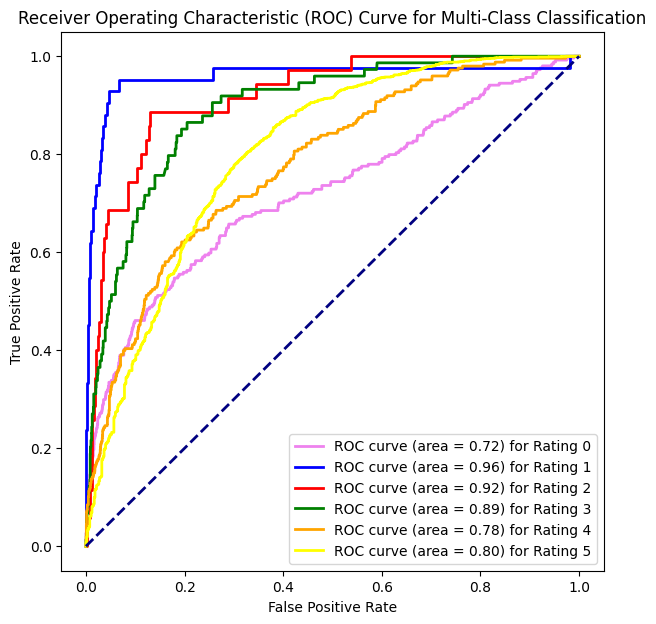

In [22]:
#Plotting ROC curve for each class

plt.figure(figsize=(7, 7))
colors = ['violet', 'blue','red', 'green', 'orange', 'yellow']
for i, color in zip(range(len(dftrain_1['Rating'].unique())), colors):
    plt.plot(L[i], M[i], color=color, lw=2, label='ROC curve (area = {:.2f}) for Rating {}'.format(roc_auc[i], i))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.show()

## Logistic Accuracy on Validation dataset

Post submitting the above mentioned LogisticRegression model, I have got an accuracy of **0.78266** on the validation dataset.

# Random Forest Classifier

In [23]:
# Defining the parameters grid
#param_grid = {
#    'RandomForest__max_depth': [None, 10, 20],
#    'RandomForest__min_samples_split': [2, 5, 10],
#    'RandomForest__min_samples_leaf': [1, 2, 4],
#    "tfidf_vectorizer__ngram_range": [(1, 2), (2, 2)],
#    "tfidf_vectorizer__max_df": [0.1, 0.2, 0.3],
#    "tfidf_vectorizer__sublinear_tf": [True, False]
#}

# Creating a pipeline with TfidfVectorizer and RandomForestClassifier
#pipe = Pipeline([
#    ('tfidf_vectorizer', TfidfVectorizer()),
#    ('RandomForest', RandomForestClassifier(random_state=55))
#])

#grid_search = GridSearchCV(estimator=pipe,
#                           param_grid=param_grid,
#                           cv=5,
#                           scoring='accuracy',
#                           verbose=1,
#                           n_jobs=-1)


#grid_search.fit(xtrain, ytrain)
#print("Best Parameters:", grid_search.best_params_)

# Getting the best model
#best_model = grid_search.best_estimator_

# Evaluating the best model on the test set
#test_accuracy = best_model.score(xtest, ytest)
#print("Test Accuracy:", test_accuracy)

## Best Parameters: RandomForestClassifier

Post fitting 5 folds for each of 324 candidates, totalling 1620 fits, the best parameters have been mentioned below - Best Parameters: 

{'RandomForest__max_depth': None, 'RandomForest__min_samples_leaf': 1, 'RandomForest__min_samples_split': 2, 'tfidf_vectorizer__max_df': 0.1, 'tfidf_vectorizer__ngram_range': (2, 2), 'tfidf_vectorizer__sublinear_tf': False}

Test Accuracy: 0.7711771177117712

In [42]:
#Random Forest on Best Parameters

# Creating a pipeline with TfidfVectorizer and Random Forest
pipe_RandomForest = Pipeline([('tfidf_vectorizer',TfidfVectorizer(ngram_range=(2, 2), max_df=0.1, sublinear_tf=False)),
                 ('RandomForest',RandomForestClassifier(random_state=55,min_samples_leaf=1,min_samples_split=2))])


pipe_RandomForest.fit(xtrain, ytrain)

# Evaluating the model on the test set
test_accuracy = pipe_RandomForest.score(xtest, ytest)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.7711771177117712


In [43]:
# Predicting labels for the test set
y_pred = pipe_RandomForest.predict(xtest)

# Generating confusion matrix
conf_matrix_logistic = confusion_matrix(ytest, y_pred)

print("Confusion Matrix:")
print(conf_matrix_logistic)

Confusion Matrix:
[[  24    2    0    0    4  224]
 [   3    5    2    0    1   31]
 [   0    3    1    1    1   29]
 [   0    1    1    1    5   66]
 [   1    0    0    0   13  234]
 [  10    0    0    0    5 2059]]


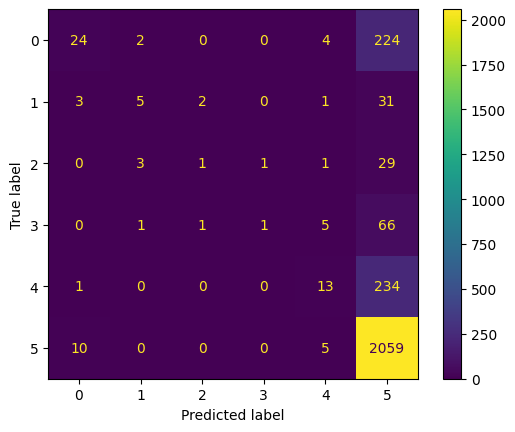

In [44]:
ConfusionMatrixDisplay(conf_matrix_logistic).plot()

In [45]:
# Predicting labels for the test set
y_pred = pipe_RandomForest.predict(xtest)

# Generating classification report
classification_report_logistic = classification_report(ytest, y_pred)

# Printing the report
print("Classification Report:")
print(classification_report_logistic)

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.09      0.16       254
           1       0.45      0.12      0.19        42
           2       0.25      0.03      0.05        35
           3       0.50      0.01      0.03        74
           4       0.45      0.05      0.09       248
           5       0.78      0.99      0.87      2074

    accuracy                           0.77      2727
   macro avg       0.51      0.22      0.23      2727
weighted avg       0.72      0.77      0.69      2727



## RandomForestClassifier Accuracy on Validation dataset

Post submitting the above mentioned RandomForestClassifier model, I have got an accuracy of **0.77584** on the validation dataset.

# SVC

In [28]:
# Defining the parameters grid
#param_grid = {
#    'SVC__C': [0.1, 1, 10],
#    'SVC__kernel': ['linear', 'rbf'],
#    "tfidf_vectorizer__ngram_range": [(1, 2), (2, 2)],
#    "tfidf_vectorizer__max_df": [0.1, 0.2, 0.3],
#    "tfidf_vectorizer__sublinear_tf": [True, False]
#}

# Creating a pipeline with TfidfVectorizer and SVC
#pipe = Pipeline([
#    ('tfidf_vectorizer', TfidfVectorizer()),
#    ('SVC', SVC(random_state=55))
#])


#grid_search = GridSearchCV(estimator=pipe,
#                           param_grid=param_grid,
#                           cv=5,
#                           scoring='accuracy',
#                           verbose=1,
#                           n_jobs=-1)


#grid_search.fit(xtrain, ytrain)
#print("Best Parameters:", grid_search.best_params_)

# Getting the best model
#best_model = grid_search.best_estimator_

# Evaluating the best model on the test set
#test_accuracy = best_model.score(xtest, ytest)
#print("Test Accuracy:", test_accuracy)

## Best Parameters: SVC

Post fitting 5 folds for each of 72 candidates, totalling 360 fits, the best parameters have been mentioned below -

Best Parameters: {'SVC__C': 1, 'SVC__kernel': 'linear', 'tfidf_vectorizer__max_df': 0.3, 'tfidf_vectorizer__ngram_range': (1, 2), 'tfidf_vectorizer__sublinear_tf': False}

Test Accuracy: 0.7774110744407774

In [48]:
#SVC on Best Parameters

# Creating a pipeline with TfidfVectorizer and SVC
pipe_SVC = Pipeline([('tfidf_vectorizer',TfidfVectorizer(ngram_range=(1, 2), max_df=0.3, sublinear_tf=False)),
                 ('SVC',SVC(random_state=55,C=1, kernel='linear'))])


pipe_SVC.fit(xtrain, ytrain)

# Evaluating the model on the test set
test_accuracy = pipe_SVC.score(xtest, ytest)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.7774110744407774


In [49]:
# Predicting labels for the test set
y_pred = pipe_SVC.predict(xtest)

# Generating confusion matrix
conf_matrix_logistic = confusion_matrix(ytest, y_pred)

print("Confusion Matrix:")
print(conf_matrix_logistic)

Confusion Matrix:
[[  19    0    0    1    0  234]
 [   3    7    2    0    0   30]
 [   1    2    0    4    7   21]
 [   1    0    2    5   10   56]
 [   2    0    1    2   25  218]
 [   8    0    0    0    2 2064]]


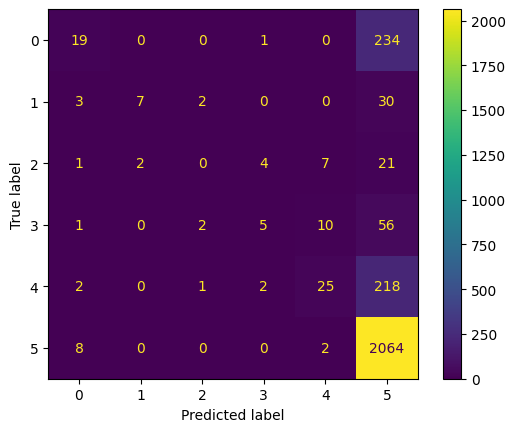

In [50]:
ConfusionMatrixDisplay(conf_matrix_logistic).plot()

In [51]:
# Predicting labels for the test set
y_pred = pipe_SVC.predict(xtest)

# Generating classification report
classification_report_logistic = classification_report(ytest, y_pred)

# Printing the report
print("Classification Report:")
print(classification_report_logistic)

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.07      0.13       254
           1       0.78      0.17      0.27        42
           2       0.00      0.00      0.00        35
           3       0.42      0.07      0.12        74
           4       0.57      0.10      0.17       248
           5       0.79      1.00      0.88      2074

    accuracy                           0.78      2727
   macro avg       0.52      0.23      0.26      2727
weighted avg       0.73      0.78      0.70      2727



## SVC Accuracy on Validation dataset

Post submitting the above mentioned SVC model, I have got an accuracy of **0.7787** on the validation dataset.

# XGBoost

In [68]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.3, sublinear_tf=True)

X_train_tfidf = tfidf_vectorizer.fit_transform(dftrain_1['Recipe_Review'])
X_test_tfidf = tfidf_vectorizer.transform(dfval['Recipe_Review'])

xtrain_,xtest_,ytrain_,ytest_ = train_test_split(X_train_tfidf,dftrain_1['Rating'],test_size=0.2,shuffle=True,stratify=dftrain_1['Rating'],random_state=55)
xtrain_.shape,ytrain_.shape, xtest_.shape,ytest_.shape

((10907, 136310), (10907,), (2727, 136310), (2727,))

In [69]:
#estimator = XGBClassifier()

# Defining the parameters grid
#param_grid = {
#    "learning_rate": [0.05, 0.1, 0.2],
#    "max_depth": [6, 8, 10],
#    "n_estimators": [10, 30, 60]
#}

# GridSearchCV
#grid_search = GridSearchCV(estimator=estimator,
#                           param_grid=param_grid,
#                           cv=5,
#                           scoring='accuracy',
#                           n_jobs=-1)

#grid_search.fit(xtrain_, ytrain_)
#print("Best Parameters:", grid_search.best_params_)

# Getting the best model
#best_model = grid_search.best_estimator_

# Evaluating the best model on the test set
#test_accuracy = best_model.score(xtest_, ytest_)
#print("Test Accuracy:", test_accuracy)

## Best Parameters: XGBoost

Best Parameters: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 60}

Test Accuracy: 0.7737440410707738

In [70]:
estimator = XGBClassifier(random_state=55, learning_rate=0.2,
                          max_depth=10, n_estimators=60)

estimator.fit(xtrain_, ytrain_)

# Evaluating the model on the test set
test_accuracy = estimator.score(xtest_, ytest_)
print("Test Accuracy:", test_accuracy)


Test Accuracy: 0.7737440410707738


In [73]:
# Predicting labels for the test set
y_pred = estimator.predict(xtest_)

# Generating confusion matrix
conf_matrix_XGB = confusion_matrix(ytest_, y_pred)

print("Confusion Matrix:")
print(conf_matrix_XGB)

Confusion Matrix:
[[  27    0    0    1    3  223]
 [   5    5    2    2    2   26]
 [   1    1    1    5    4   23]
 [   3    0    0    6    6   59]
 [   7    0    0    4   29  208]
 [  14    1    0    1   16 2042]]


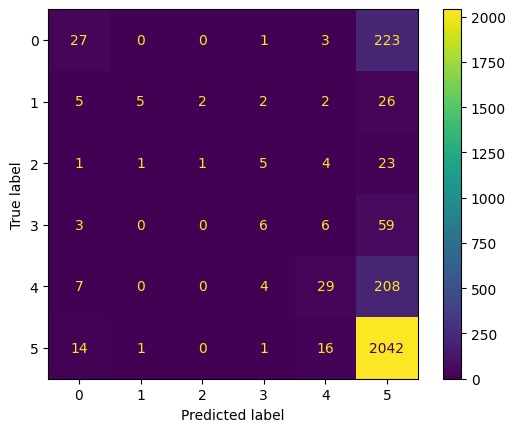

In [74]:
ConfusionMatrixDisplay(conf_matrix_XGB).plot()

In [75]:
# Predicting labels for the test set
y_pred = estimator.predict(xtest_)

# Generating classification report
classification_report_XGB = classification_report(ytest_, y_pred)

# Printing the report
print("Classification Report:")
print(classification_report_XGB)

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.11      0.17       254
           1       0.71      0.12      0.20        42
           2       0.33      0.03      0.05        35
           3       0.32      0.08      0.13        74
           4       0.48      0.12      0.19       248
           5       0.79      0.98      0.88      2074

    accuracy                           0.77      2727
   macro avg       0.52      0.24      0.27      2727
weighted avg       0.71      0.77      0.71      2727



In [71]:
#score = estimator.predict(X_test_tfidf)
#score = pd.DataFrame(data={
#    "ID":range(1,4547),"Rating":score
#})

## XGBoost Accuracy on Validation dataset

Post submitting the above mentioned XGBoost model, I have got an accuracy of **0.78046** on the validation dataset.

# Model Comparison

Based on the validation results obtained for the logistic regression, random forest, support vector classifier (SVC), and XGBoost models, it's evident that all models perform relatively well, with accuracies ranging from approximately 77.58% to 78.27%.

##### Logistic Regression: 0.78266
##### Random Forest: 0.77584
##### Support Vector Classifier (SVC): 0.7787
##### XGBoost: 0.78046

Logistic Regression slightly outperforms the other models with an accuracy of 78.27%, the differences in accuracy between the models are marginal. In conclusion, Logistic Regression will be preferred due to its slightly higher accuracy on the validation dataset. 

# Submission

In [23]:
score = pipe_logistic.predict(dfval['Recipe_Review'])
score = pd.DataFrame(data={
    "ID":range(1,4547),"Rating":score
})

In [24]:
with open("/kaggle/working/submission.csv","w") as w:
    score.to_csv(path_or_buf=w, index=False)